# Model and Exogenous Variables Selection

We currently have a dataset with a large number of exogenous variables, which we classify into the following groups:
- **Essential Variables** (Past Lags and Future Steps)
- **Temporal Variables and Historical Aggregates**
- **Geographical and Climatological Variables**
- **Soil and Demographic Variables**

To ensure optimal performance in our predictions, we will conduct an exploratory process where we aim to make predictions on a blind test set (generated by us) by progressively incorporating these different sets of variables.

In each case, we will fit various types of models, focusing primarily on tree-based models (XGBoost, LightGBM, Random Forest, CatBoost) while also fitting some more classical models (Ridge, ElasticNet). 

For each set of predictive variables and model, we will test different combinations of hyperparameters using Randomized Search and Cross Validation. 

This approach will allow us to determine the most suitable set of predictive variables for our data and identify which models achieve the best performance.

*(Prior to this notebook, we performed initial prediction tests using a single model to forecast the time series for all locations, as well as aggregating by region. However, better results were obtained by using a distinct, individualized model for each location, primarily due to the sufficient number of observations available for all locations.)*

#### Loading necessary libraries

In [6]:
import os
import gc
import time
import random
import json
import glob
import itertools
import datetime
import numpy as np
import pandas as pd
import psutil  # For memory monitoring

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GroupKFold, train_test_split, KFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


#### Loading necessary data

In [4]:
complete_training_data_df = pd.read_csv("complete_and_fully_processed_data.csv")
complete_training_data_df['id_loc'] = complete_training_data_df['id_loc'].astype(str)

### Train - Test division

In the following instruction the blind test data, which will also be used to calculate the baseline "predictions" is generated:

In [5]:
training_data_df, blind_test_data = train_test_split(complete_training_data_df, test_size=0.2, random_state=2, stratify=complete_training_data_df['id_loc'])

In [ ]:
blind_test_data.to_csv("blind_test.csv", index = False)

### Defining exogenous variable groups 

In [6]:
necessary_vars = training_data_df.columns[list(range(0, 77)) + [136]]
hist_temp_vars = training_data_df.columns[list(range(77, 136))]
geogr_climate_vars = training_data_df.columns[list(range(137, 282))]
soil_demogr_vars = training_data_df.columns[list(range(282, 384))]

We train the different models for the 4 sets of variables, generating a result file for each one, which will enable us to compare their performances.

In [5]:
# Empezamos con las variables necesarias únicamente

# FINISHED:
# training_data_df = training_data_df[necessary_vars]
# blind_test_data = blind_test_data[necessary_vars]

# FINISHED:
# training_data_df = training_data_df[necessary_vars.append(hist_temp_vars)]
# blind_test_data = blind_test_data[necessary_vars.append(hist_temp_vars)]

# FINISHED:
training_data_df = training_data_df[necessary_vars.append(hist_temp_vars).append(geogr_climate_vars)]
blind_test_data = blind_test_data[necessary_vars.append(hist_temp_vars).append(geogr_climate_vars)]

# FINISHED:
# training_data_df = training_data_df[necessary_vars.append(hist_temp_vars).append(geogr_climate_vars).append(soil_demogr_vars)]
# blind_test_data = blind_test_data[necessary_vars.append(hist_temp_vars).append(geogr_climate_vars).append(soil_demogr_vars)]

## Model training

In [6]:
# Function to clean and prepare the dataset (removes missing values and resets index)
def prepare_data(df, lag_columns, step_columns):
    """
    Cleans the dataset by removing any missing values and resetting the index.
    
    Parameters:
    df (pd.DataFrame): The input dataset containing features and target columns.
    lag_columns (list): List of lag column names.
    step_columns (list): List of step column names.

    Returns:
    pd.DataFrame: Cleaned dataset without missing values and with reset index.
    """
    df = df.dropna().reset_index(drop=True)
    return df


# Function to compute the SMAPE (Symmetric Mean Absolute Percentage Error) score
def smape(a, f):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE) between actual and forecasted values.
    
    Parameters:
    a (np.array): The actual values.
    f (np.array): The forecasted values.

    Returns:
    float: The SMAPE score, or NaN if no valid data is available.
    """
    a, f = np.asarray(a), np.asarray(f)
    mask = np.isfinite(a) & np.isfinite(f) & ((np.abs(a) + np.abs(f)) != 0)
    if np.any(mask):
        return 100 * np.mean(2 * np.abs(f[mask] - a[mask]) / (np.abs(a[mask]) + np.abs(f[mask])))
    return np.nan


# Create a custom scorer for SMAPE, where lower scores are better
smape_scorer = make_scorer(smape, greater_is_better=False)


# Function to define models and their hyperparameter grids for tuning
def get_model_and_hyperparams():
    """
    Defines machine learning models and their respective hyperparameter grids.
    
    Returns:
    dict: A dictionary where each key is a model name and each value is a dict containing:
          - 'model': the model object
          - 'params': the hyperparameter grid for the model
    """
    models_and_grids = {
        'ridge': {
            'model': Ridge(),
            'params': {
                'alpha': [0.01, 0.1, 1.0, 10.0],
                'solver': ['auto', 'svd', 'saga'],
                'tol': [1e-4, 1e-3, 1e-2]
            }
        },
        'elasticnet': {
            'model': ElasticNet(),
            'params': {
                'alpha': [0.01, 0.1, 1.0, 10.0],
                'l1_ratio': [0.1, 0.5, 0.9],
                'max_iter': [1000, 2000],
                'tol': [1e-4, 1e-3, 1e-2]
            }
        },
        # Additional models like LightGBM, XGBoost, RandomForest, and CatBoost defined below
    }
    return models_and_grids


# Function to monitor memory usage and stop execution if memory exceeds a limit
def check_memory_usage(limit_gb=11):
    """
    Checks the current memory usage of the process and compares it to a specified limit.
    
    Parameters:
    limit_gb (int): Memory limit in gigabytes (GB) after which the process should stop.

    Returns:
    bool: True if the memory usage exceeds the limit, False otherwise.
    """
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    memory_used_gb = memory_info.rss / (1024 ** 3)  # Convert memory usage to GB
    return memory_used_gb > limit_gb


# Function to save the best model and its parameters to a JSON file
def save_best_model(json_file, id_loc, model_name, best_params, smape_test, smape_cv):
    """
    Saves the best model's parameters and performance metrics to a JSON file.
    
    Parameters:
    json_file (str): The path to the JSON file where results are saved.
    id_loc (str): The unique identifier for the location being modeled.
    model_name (str): The name of the model.
    best_params (dict): The best hyperparameters for the model.
    smape_test (float): SMAPE score on the test set.
    smape_cv (float): SMAPE score on the cross-validation set.
    """
    if os.path.exists(json_file):
        with open(json_file, 'r') as f:
            results = json.load(f)
    else:
        results = {}

    if (id_loc not in results) or (smape_test < results[id_loc]['smape_test']) or (
            np.isclose(smape_test, results[id_loc]['smape_test']) and smape_cv < results[id_loc]['smape_cv']):
        results[id_loc] = {
            'model': model_name,
            'best_params': best_params,
            'smape_test': smape_test,
            'smape_cv': smape_cv
        }

    with open(json_file, 'w') as f:
        json.dump(results, f, indent=4)


# Function to train a model using cross-validation and evaluate its performance
def train_and_evaluate_model(model_name, model, param_grid, X_train, y_train, n_folds=7, memory_limit_gb=11):
    """
    Trains a given model using cross-validation, tunes hyperparameters, and evaluates performance using SMAPE.

    Parameters:
    model_name (str): The name of the model being trained.
    model: The machine learning model object.
    param_grid (dict): The hyperparameter grid for the model.
    X_train (pd.DataFrame): The input features for training.
    y_train (pd.DataFrame): The target values for training.
    n_folds (int): The number of folds for cross-validation.
    memory_limit_gb (int): Memory limit in gigabytes (GB) to prevent memory overload.

    Returns:
    model: The best-trained model.
    dict: The best hyperparameters found during tuning.
    float: The mean SMAPE score from cross-validation.
    """
    cv = KFold(n_splits=n_folds, random_state=42, shuffle=True)
    
    if model_name in ['ridge', 'elasticnet', 'lightgbm', 'randomforest']:
        smape_cv_scores = []
        multi_model = MultiOutputRegressor(model)
        
        for train_idx, val_idx in cv.split(X_train):
            X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            if check_memory_usage(memory_limit_gb):
                print(f"Memory limit reached during training {model_name}. Skipping this iteration.")
                return None, None, np.inf
            
            multi_model.fit(X_cv_train, y_cv_train)
            y_cv_pred = multi_model.predict(X_cv_val)
            smape_cv = smape(y_cv_val.values, y_cv_pred)
            smape_cv_scores.append(smape_cv)
        
        mean_smape_cv = np.mean(smape_cv_scores)
        return multi_model, model.get_params(), mean_smape_cv
    
    else:
        # Case for XGBoost or CatBoost
        randomized_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            n_iter=7,
            cv=cv,
            scoring=smape_scorer,
            random_state=42,
            verbose=0,
            refit=True,
            n_jobs=-1
        )
        
        try:
            if check_memory_usage(memory_limit_gb):
                print(f"Memory limit reached during training {model_name}. Skipping this iteration.")
                return None, None, np.inf
            
            randomized_search.fit(X_train, y_train)
        except MemoryError:
            print(f"Memory limit reached during training {model_name}. Skipping this iteration.")
            return None, None, np.inf
        
        return randomized_search.best_estimator_, randomized_search.best_params_, -randomized_search.best_score_


# Main function to train models for all unique id_loc
def train_model_for_all_id_locs(model_name, model_info, training_data_df, lag_columns, step_columns, blind_test_data, json_file, n_folds=7, memory_limit_gb=11):
    """
    Trains and evaluates a model for all unique locations (id_loc) in the dataset.

    Parameters:
    model_name (str): The name of the model being trained.
    model_info (dict): The model and hyperparameter grid information.
    training_data_df (pd.DataFrame): The dataset containing training data.
    lag_columns (list): List of lag columns.
    step_columns (list): List of step columns (target variables).
    blind_test_data (pd.DataFrame): The blind test set for evaluation.
    json_file (str): The path to the JSON file where results are saved.
    n_folds (int): Number of cross-validation folds.
    memory_limit_gb (int): Memory limit in gigabytes (GB).
    """
    unique_id_loc = training_data_df['id_loc'].unique()[131:]
    total_locs = len(unique_id_loc)  
    training_data_df = prepare_data(training_data_df, lag_columns, step_columns)

    for idx, id_loc in enumerate(unique_id_loc, 1):
        print(f"\nTraining {model_name} for location {id_loc} (Iteration {idx} of {total_locs})")
        loc_data = training_data_df[training_data_df['id_loc'] == id_loc]
        X = loc_data.drop(step_columns + ['id_loc', 'Zone'], axis=1)
        y = loc_data[step_columns]

        X_test = blind_test_data[blind_test_data['id_loc'] == id_loc].drop(step_columns + ['id_loc', 'Zone'], axis=1)
        y_test = blind_test_data[blind_test_data['id_loc'] == id_loc][step_columns]

        model = model_info['model']
        param_grid = model_info['params']
        best_model, best_params, smape_cv = train_and_evaluate_model(model_name, model, param_grid, X, y, n_folds, memory_limit_gb)

        if best_model is None:
            print(f"Skipping {model_name} for id_loc {id_loc} due to memory issues.")
            continue

        y_pred_test = best_model.predict(X_test)
        smape_test = smape(y_test.values, y_pred_test)
        print(f"{model_name} Test SMAPE for id_loc {id_loc}: {smape_test:.2f}%")

        save_best_model(json_file, id_loc, model_name, best_params, smape_test, smape_cv)

        del X, y, X_test, y_test, best_model, y_pred_test
        gc.collect()

    print(f"\nTraining completed for {model_name}.")
    
    temp_json_file = f"temp_{model_name}_models.json"
    print(f"Saving temporary JSON: {temp_json_file}")
    with open(temp_json_file, 'w') as f:
        with open(json_file, 'r') as original_json:
            f.write(original_json.read())


# Main function to iterate over all models and train them
def train_models_for_each_model(training_data_df, lag_columns, step_columns, blind_test_data, json_file, n_folds=7, memory_limit_gb=11):
    """
    Iterates through all defined models and trains them for all id_locs.

    Parameters:
    training_data_df (pd.DataFrame): The dataset containing training data.
    lag_columns (list): List of lag columns.
    step_columns (list): List of step columns (target variables).
    blind_test_data (pd.DataFrame): The blind test set for evaluation.
    json_file (str): The path to the JSON file where results are saved.
    n_folds (int): Number of cross-validation folds.
    memory_limit_gb (int): Memory limit in gigabytes (GB).
    """
    models_and_grids = get_model_and_hyperparams()

    for model_name, model_info in models_and_grids.items():
        print(f"\n***** Starting training with {model_name.upper()} *****")
        train_model_for_all_id_locs(model_name, model_info, training_data_df, lag_columns, step_columns, blind_test_data, json_file, n_folds, memory_limit_gb)

# Configuración del pipeline
lag_columns = [f'lag_{i}' for i in range(50, 0, -1)]
step_columns = [f'step_{i}' for i in range(1, 27)]

# Archivo JSON donde se almacenan los mejores modelos y sus hiperparámetros
# json_file = 'best_models_necessary_vars.json' # FINISHED
# json_file = 'best_models_necessary_vars_hist_temp_vars.json' # FINISHED
# json_file = 'best_models_necessary_vars_hist_temp_vars_geogr_climate_vars.json' # FINISHED
# json_file = 'best_models_necessary_vars_hist_temp_vars_geogr_climate_vars_soil_demogr_vars.json' # FINISHED

# Calling the main pipeline
train_models_for_each_model(training_data_df, lag_columns, step_columns, blind_test_data, json_file)


***** Iniciando entrenamiento con CATBOOST *****

Training catboost for location 312660 (Iteración 1 de 356)
catboost Test SMAPE for id_loc 312660: 0.04%

Training catboost for location 305524 (Iteración 2 de 356)
catboost Test SMAPE for id_loc 305524: 0.16%

Training catboost for location 311266 (Iteración 3 de 356)
catboost Test SMAPE for id_loc 311266: 0.05%

Training catboost for location 300996 (Iteración 4 de 356)
catboost Test SMAPE for id_loc 300996: 0.04%

Training catboost for location 304675 (Iteración 5 de 356)
catboost Test SMAPE for id_loc 304675: 0.08%

Training catboost for location 327536 (Iteración 6 de 356)
catboost Test SMAPE for id_loc 327536: 0.05%

Training catboost for location 321430 (Iteración 7 de 356)
catboost Test SMAPE for id_loc 321430: 0.02%

Training catboost for location 326843 (Iteración 8 de 356)
catboost Test SMAPE for id_loc 326843: 0.15%

Training catboost for location 313833 (Iteración 9 de 356)
catboost Test SMAPE for id_loc 313833: 0.21%

Trai

catboost Test SMAPE for id_loc 375923: 0.05%

Training catboost for location 301838 (Iteración 79 de 356)
catboost Test SMAPE for id_loc 301838: 0.05%

Training catboost for location 326298 (Iteración 80 de 356)
catboost Test SMAPE for id_loc 326298: 0.07%

Training catboost for location 329847 (Iteración 81 de 356)
catboost Test SMAPE for id_loc 329847: 0.07%

Training catboost for location 317594 (Iteración 82 de 356)
catboost Test SMAPE for id_loc 317594: 0.16%

Training catboost for location 304071 (Iteración 83 de 356)
catboost Test SMAPE for id_loc 304071: 0.04%

Training catboost for location 335539 (Iteración 84 de 356)
catboost Test SMAPE for id_loc 335539: 0.06%

Training catboost for location 319921 (Iteración 85 de 356)
catboost Test SMAPE for id_loc 319921: 0.05%

Training catboost for location 324095 (Iteración 86 de 356)
catboost Test SMAPE for id_loc 324095: 0.03%

Training catboost for location 320747 (Iteración 87 de 356)
catboost Test SMAPE for id_loc 320747: 0.06%



catboost Test SMAPE for id_loc 304600: 0.11%

Training catboost for location 326280 (Iteración 156 de 356)
catboost Test SMAPE for id_loc 326280: 0.10%

Training catboost for location 301846 (Iteración 157 de 356)
catboost Test SMAPE for id_loc 301846: 0.03%

Training catboost for location 316174 (Iteración 158 de 356)
catboost Test SMAPE for id_loc 316174: 0.15%

Training catboost for location 313239 (Iteración 159 de 356)
catboost Test SMAPE for id_loc 313239: 0.06%

Training catboost for location 316356 (Iteración 160 de 356)
catboost Test SMAPE for id_loc 316356: 0.02%

Training catboost for location 319442 (Iteración 161 de 356)
catboost Test SMAPE for id_loc 319442: 0.06%

Training catboost for location 322578 (Iteración 162 de 356)
catboost Test SMAPE for id_loc 322578: 0.03%

Training catboost for location 327171 (Iteración 163 de 356)
catboost Test SMAPE for id_loc 327171: 0.06%

Training catboost for location 345371 (Iteración 164 de 356)
catboost Test SMAPE for id_loc 345371

catboost Test SMAPE for id_loc 323709: 0.04%

Training catboost for location 329995 (Iteración 233 de 356)
catboost Test SMAPE for id_loc 329995: 0.02%

Training catboost for location 345017 (Iteración 234 de 356)
catboost Test SMAPE for id_loc 345017: 0.08%

Training catboost for location 345652 (Iteración 235 de 356)
catboost Test SMAPE for id_loc 345652: 0.08%

Training catboost for location 317461 (Iteración 236 de 356)
catboost Test SMAPE for id_loc 317461: 0.05%

Training catboost for location 306928 (Iteración 237 de 356)
catboost Test SMAPE for id_loc 306928: 0.10%

Training catboost for location 345256 (Iteración 238 de 356)
catboost Test SMAPE for id_loc 345256: 0.06%

Training catboost for location 329144 (Iteración 239 de 356)
catboost Test SMAPE for id_loc 329144: 0.03%

Training catboost for location 305953 (Iteración 240 de 356)
catboost Test SMAPE for id_loc 305953: 0.13%

Training catboost for location 328443 (Iteración 241 de 356)
catboost Test SMAPE for id_loc 328443

catboost Test SMAPE for id_loc 345116: 0.08%

Training catboost for location 323675 (Iteración 310 de 356)
catboost Test SMAPE for id_loc 323675: 0.04%

Training catboost for location 325894 (Iteración 311 de 356)
catboost Test SMAPE for id_loc 325894: 0.07%

Training catboost for location 335943 (Iteración 312 de 356)
catboost Test SMAPE for id_loc 335943: 0.03%

Training catboost for location 326264 (Iteración 313 de 356)
catboost Test SMAPE for id_loc 326264: 0.02%

Training catboost for location 326447 (Iteración 314 de 356)
catboost Test SMAPE for id_loc 326447: 0.08%

Training catboost for location 335646 (Iteración 315 de 356)
catboost Test SMAPE for id_loc 335646: 0.11%

Training catboost for location 335109 (Iteración 316 de 356)
catboost Test SMAPE for id_loc 335109: 0.11%

Training catboost for location 311381 (Iteración 317 de 356)
catboost Test SMAPE for id_loc 311381: 0.11%

Training catboost for location 321752 (Iteración 318 de 356)
catboost Test SMAPE for id_loc 321752

## Visualization of training results from the generated json files

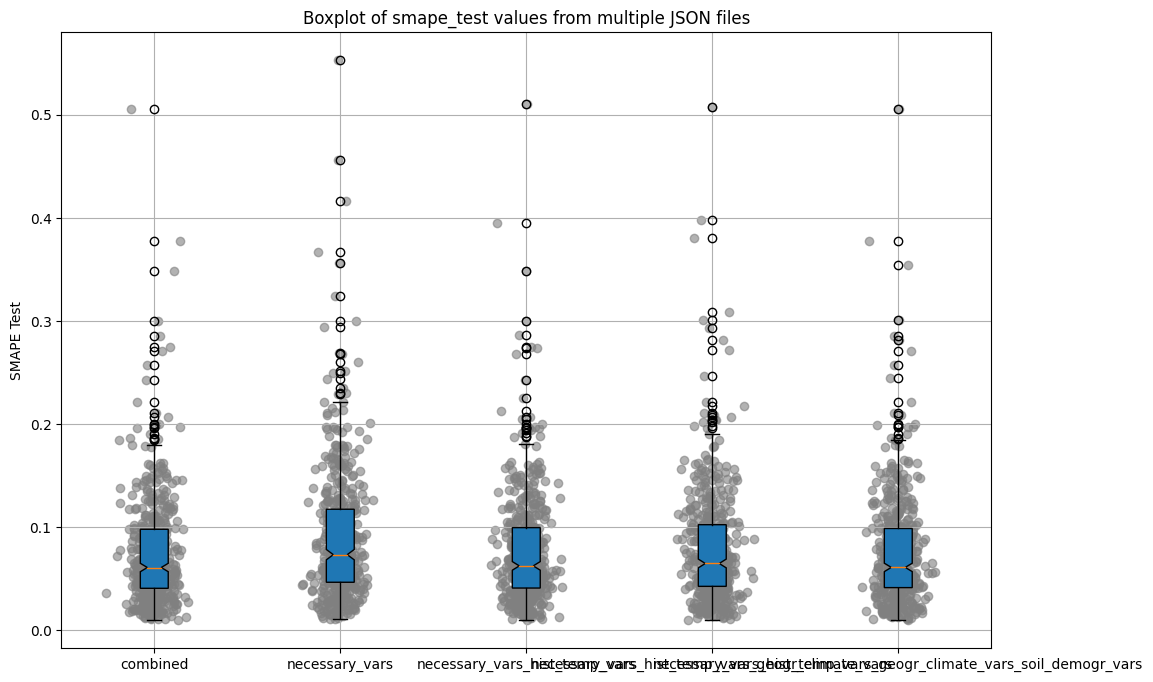

In [8]:
# Function to load and extract smape_test values from a JSON file
def load_smape_test_values(filepath):
    """
    Loads a JSON file and extracts the 'smape_test' values from the data.

    Parameters:
    filepath (str): Path to the JSON file.

    Returns:
    list: A list of 'smape_test' values extracted from the JSON file.
    """
    with open(filepath, 'r') as f:
        data = json.load(f)
    return [values['smape_test'] for values in data.values()]

# Search for all JSON files that start with "best_models_"
json_files = glob.glob("best_models_*.json")

# Dictionary to store smape_test values for each file
smape_test_data = {}
for file in json_files:
    # Extract a key based on the file name, removing the prefix and extension
    key = os.path.basename(file).replace("best_models_", "").replace(".json", "")
    
    # Load and store the smape_test values for the corresponding file
    smape_test_data[key] = load_smape_test_values(file)

# Create a boxplot to visualize smape_test values from each file
plt.figure(figsize=(12, 8))

# Initialize lists to store all smape_test values and jittered x-coordinates for plotting
all_smape_values = []
all_jitter = []
positions = []

# Loop through the collected smape_test data and plot each as a separate boxplot
for i, (key, smape_test_values) in enumerate(smape_test_data.items(), start=1):
    # Generate jitter (small random noise) to spread the points for better visualization
    x_jitter = i + np.random.normal(0, 0.066, len(smape_test_values))
    all_jitter.append(x_jitter)
    all_smape_values.append(smape_test_values)
    
    # Add the position for the current boxplot
    positions.append(i)

    # Draw the boxplot for the current set of smape_test values
    plt.boxplot(smape_test_values, positions=[i], patch_artist=True, notch=True)

    # Scatter plot to display individual points with jitter
    plt.scatter(x_jitter, smape_test_values, color='grey', alpha=0.6)

# Set plot title and axis labels
plt.title('Boxplot of smape_test values from multiple JSON files')
plt.ylabel('SMAPE Test')
plt.xticks(positions, list(smape_test_data.keys()))  # Set x-axis labels as the file keys
plt.grid(True)  # Enable grid for better readability

# Show the final plot
plt.show()

## Results table

|                           |                                                                                                   | Mean SMAPE | SMAPE Std. Dev. | SMPAE Q1 | SMAPE Q2 | SMAPE Q3 |
|---------------------------|---------------------------------------------------------------------------------------------------|------------|-----------------|----------|----------|----------|
|    Baseline Predictions   | Baseline 1 (Constant previous month)                                                              |   0.1725   |      0.1643     |  0.0702  |  0.1244  |  0.2182  |
|                           | Baseline 2 (Constant average last 4y)                                                             |   0.1651   |      0.1614     |  0.0661  |  0.1174  |  0.2137  |
|                           | Baseline 3 (Value 2y ago)                                                                         |   0.1859   |      0.1719     |  0.0759  |  0.1386  |  0.2401  |
|                           | Baseline 4 (Average of lags 24, 36 and 48)                                                        |   0.1700   |      0.1656     |  0.0674  |  0.1219  |  0.2189  |
| Trained model Predictions | Lags only                                                                                         |   0.0898   |      0.0655     |  0.0464  |  0.0732  |  0.1173  |
|                           | Lags +  Hisoric aggregates                                                                        |   0.0766   |      0.0556     |  0.0408  |  0.0623  |  0.0994  |
|                           | Lags +  Historic aggregates + Geographical and climate variables                                  |   0.0786   |      0.0568     |  0.0424  |  0.0647  |  0.1023  |
|                           | Lags + Historic aggregates + Geographical and climate variables +  Soil and demographic variables |   0.0759   |      0.0550     |  0.0413  |  0.0609  |  0.0986  |
|                           | Combined*                                                                                         |   0.0751   |      0.0548     |  0.0406  |  0.0608  |   0.978  |

### Distribution of model types across the generated json files

C:\Users\local_sds708\Temp\ipykernel_11332\3806585941.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

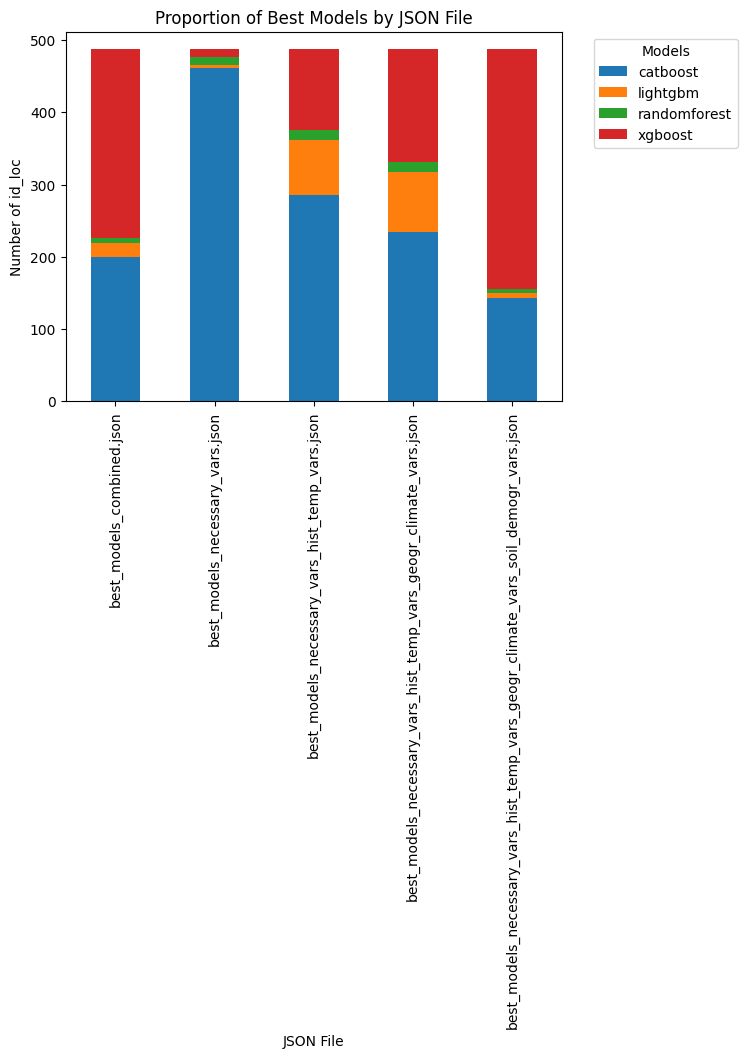

In [17]:
# Define the directory where the JSON files are located
json_dir = '.'

# List all JSON files that start with "best_models"
json_files = [f for f in os.listdir(json_dir) if f.startswith("best_models") and f.endswith(".json")]

# Dictionary to store models for each id_loc from each JSON file
models_by_file = {}
id_loc_list = []

# Load each JSON file and extract model information
for json_file in json_files:
    with open(os.path.join(json_dir, json_file), 'r') as file:
        data = json.load(file)
        
        # Extract models for each id_loc and store them in the dictionary
        models_by_file[json_file] = {id_loc: info['model'] for id_loc, info in data.items()}
        
        # Assuming all JSON files have the same id_loc, we capture the list of id_loc from the first file
        if not id_loc_list:
            id_loc_list = list(data.keys())

# Create a DataFrame with the models for each id_loc and JSON file
models_df = pd.DataFrame(models_by_file)

# Plot 1: Proportion of best models (CatBoost, XGBoost, etc.) by JSON file
# Count the occurrence of each model type per file (id_loc) and fill NaN values with 0
model_counts = models_df.apply(pd.Series.value_counts).fillna(0)

# Create the plot
plt.figure(figsize=(10, 6))
model_counts.T.plot(kind='bar', stacked=True)
plt.title('Proportion of Best Models by JSON File')
plt.xlabel('JSON File')
plt.ylabel('Number of id_loc')
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

### Distribution of the predictor variable set across the best model for each location

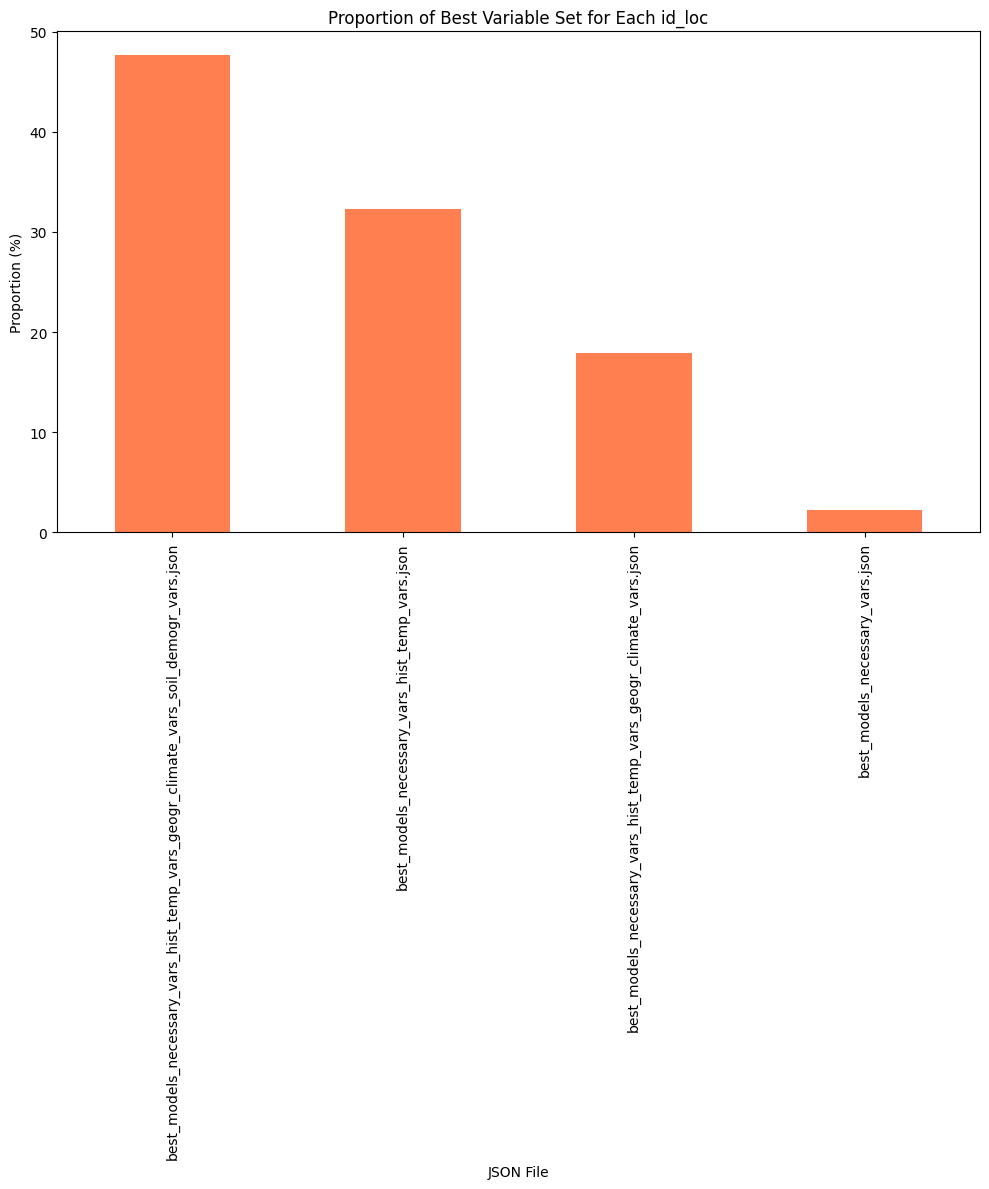

In [18]:
# Dictionary to store SMAPE values for each id_loc and JSON file
smape_data = {}

# Iterate through each JSON file and extract the SMAPE values for each id_loc
for json_file in json_files:
    file_path = os.path.join(json_dir, json_file)

    # Exclude the combined file from the analysis
    if json_file != 'best_models_combined.json':
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        # Extract SMAPE for each id_loc
        for id_loc, model_info in data.items():
            smape = model_info['smape_test']
            
            # If the id_loc is not in the dictionary, add it
            if id_loc not in smape_data:
                smape_data[id_loc] = {}
            
            # Store the SMAPE value for this JSON file and id_loc
            smape_data[id_loc][json_file] = smape

# Create a DataFrame from the SMAPE dictionary and transpose it so id_loc are rows
smape_df = pd.DataFrame(smape_data).T

# Find the file (set of variables) with the best SMAPE for each id_loc
best_json_per_id_loc = smape_df.idxmin(axis=1)  # Find the file with the lowest SMAPE

# Count the frequency of the best JSON file for each id_loc and calculate the percentage
best_json_counts = best_json_per_id_loc.value_counts(normalize=True) * 100

# Create a bar chart to show the proportion of the best variable sets for each id_loc
plt.figure(figsize=(10, 12))
best_json_counts.plot(kind='bar', color='coral')
plt.title('Proportion of Best Variable Set for Each id_loc')
plt.ylabel('Proportion (%)')
plt.xlabel('JSON File')
plt.xticks(rotation=90)
plt.tight_layout()

# Display the chart
plt.show()

### Key Takeaways from the Previous Charts and Results Table:

- There is no significant difference in terms of the predictor variable set that achieves the best results. We observe worse performance with the smallest set of variables, while nearly half of the locations reach their best model performance with the largest set of predictive variables, which includes all available features. However, the difference is not sufficiently clear.

- Across the different sets of predictor variables, the distribution of the best models varies. For the simplest set of variables, CatBoost dominates, but as the variable set expands, XGBoost gains prominence. Notably, neither Ridge nor ElasticNet emerged as the best model in any scenario.

Motivated by the apparent diversity in the best model for predicting each location, we decided to adopt a 'combined' approach. Instead of selecting a single model or predictor variable set to train models for all locations, we opted to select the model and variables for each location based on individual performance. For instance, one specific location may be predicted using a CatBoost model that leverages only the essential variables, while another location could be predicted using XGBoost with all available features.

Thus, in several charts and the table, we can observe that the 'combined' approach obtains the best predictions on the blind test set. st set.
